# *****************************************************************************
#
#	brief : 라벨링 및 전처리한 데이터 merged_file.csv을 사용해 학습해 비활동성, 활동성 감정 분석을 학습합니다.
#			(본 코드는 네이버 리뷰 긍정,부정 감정분석기 코드를 재활용하였습니다)
#	file : Determining_Activity.ipynb
#	date : 2023-10-18
#	autor : 김선민
#
# *****************************************************************************

In [12]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import urllib.request
from kiwipiepy import Kiwi
from collections import Counter
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [41]:
# CSV 파일을 읽어 데이터프레임 생성, 열 이름 설정, 데이터프레임의 길이 출력, 데이터프레임의 처음 몇 행 출력

df = pd.read_csv("Json_PreProcessing/CSV_DATA/merged_file.csv", sep="\t", header=None, encoding="utf-8-sig")
df.columns = ['reviews', 'label']
print(len(df))
df.head()

1560114


,reviews,label
0,나 홍콩도,1
1,가보고픔 ㅠㅠ,1
2,앜ㅋㅋ 혹시,1
3,홍콩에 잘생긴사람,1
4,있다구해서?,1


In [18]:
# 중복 리뷰를 삭제하고, NaN 값 확인 및 데이터프레임 길이 출력
df.drop_duplicates(subset=['reviews'], inplace=True)
print(df.isnull().values.any())
print(len(df))

# 리뷰 텍스트에서 한글 문자 이외의 문자를 삭제하고, 빈 문자열을 NaN으로 대체하며, NaN 값 개수 출력
df['reviews'] = df['reviews'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣]", "")
df['reviews'].replace('', np.nan, inplace=True)
print(df.isnull().sum())

True
1263165
reviews    1
label      0
dtype: int64


Train Reviews :  1010532
Test_Reviews :  252633
   label   count
0      0  493583
1      1  516949


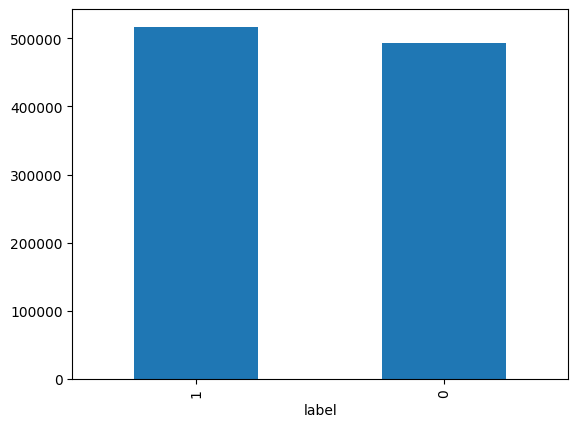

In [19]:
# 데이터를 학습 데이터와 테스트 데이터로 분할하고 데이터 개수 출력
train_data, test_data = train_test_split(df, test_size=0.2, random_state=97)
print("Train Reviews : ", len(train_data))
print("Test_Reviews : ", len(test_data))

# 학습 데이터의 레이블 분포를 막대 그래프로 표시하고, 레이블별 데이터 개수 출력
train_data['label'].value_counts().plot(kind='bar')
print(train_data.groupby('label').size().reset_index(name='count'))

In [20]:
# Kiwi 객체 생성 및 불용어(stopwords) 정의
# Kiwi 한국어 형태소 분석기 라이브러리 사용
kiwi = Kiwi()
stopwords = ['도', '는', '다', '의', '가', '이', '은', '한', '에', '하', '고', '을', '를', '인', '듯', '과', '와', '네', '들', '듯', '지',
			 '임', '게']

# 문장을 토큰화하는 함수 정의
def tokenizing(sentence):
	try:
		if not sentence:
			raise ValueError
		words = []  # 변수를 초기화
		tokens = kiwi.tokenize(sentence)
		for token in tokens:
			if token[0] not in stopwords:
				words.append(token[0])
	except ValueError as e:
		print(e)

	return words

# 학습 데이터와 테스트 데이터에 토큰화 함수 적용
train_data['tokenized'] = train_data['reviews'].apply(tokenizing)
print("train finished")
test_data['tokenized'] = test_data['reviews'].apply(tokenizing)
print("test finished")

`analyze` requires a `str` or an iterable of `str` parameters.
train finished
test finished


In [21]:
# 부정적 리뷰단어 추출
negative_words = np.hstack(train_data[train_data.label == 0]['tokenized'].values)
# 긍정적 리뷰에서 단어 추출
positive_words = np.hstack(train_data[train_data.label == 1]['tokenized'].values)

In [22]:
# 부정적 리뷰 상위 20개 단어
negative_word_count = Counter(negative_words)
print(negative_word_count.most_common(20))

[('어', 155448), ('나', 69423), ('었', 64532), ('ᆫ', 63265), ('거', 50184), ('?', 47492), ('어서', 41516), ('보', 34675), ('안', 33606), ('ᆯ', 33201), ('있', 26233), ('먹', 24865), ('는데', 24066), ('되', 22866), ('면', 22262), ('어야', 20832), ('..', 19625), ('...', 19593), ('오', 18836), ('ᆷ', 18784)]


In [23]:
# 긍정 리뷰에서 가장 많이 나타나는 상위 20개 단어 출력
positive_word_count = Counter(positive_words)
print(positive_word_count.most_common(20))

[('어', 149854), ('나', 68912), ('보', 63721), ('었', 63528), ('ᆫ', 60363), ('?', 60290), ('거', 45420), ('ᆯ', 38479), ('어서', 33061), ('있', 27402), ('안', 25046), ('면', 23926), ('는데', 21589), ('키키', 21337), ('되', 20989), ('오', 20885), ('야', 20084), ('...', 19894), ('좋', 19765), ('ᆷ', 19448)]


긍정 리뷰의 평균 길이 : 6.256180010020331
부정 리뷰의 평균 길이 : 6.3623605351075705


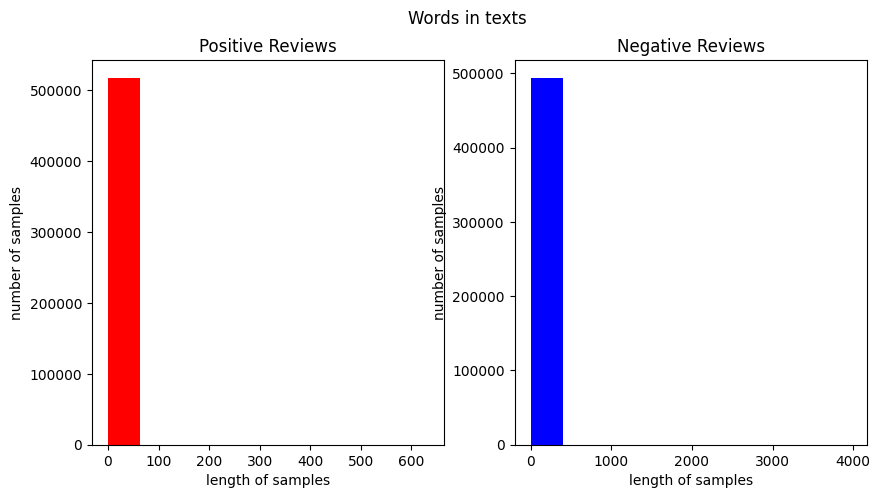

In [24]:
# 활동적 리뷰의 길이 분포 그래프
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
text_len = train_data[train_data['label'] == 1]['tokenized'].map(lambda x: len(x))
ax1.hist(text_len, color='red')
ax1.set_title('Positive Reviews')
ax1.set_xlabel('length of samples')
ax1.set_ylabel('number of samples')
print('활동성 리뷰의 평균 길이 :', np.mean(text_len))

# 비활동적 리뷰의 길이 분포 그래프
text_len = train_data[train_data['label'] == 0]['tokenized'].map(lambda x: len(x))
ax2.hist(text_len, color='blue')
ax2.set_title('Negative Reviews')
fig.suptitle('Words in texts')
ax2.set_xlabel('length of samples')
ax2.set_ylabel('number of samples')
print('비활동성 리뷰의 평균 길이 :', np.mean(text_len))
plt.show()

In [25]:
# 학습 데이터와 테스트 데이터의 토큰화된 리뷰 및 레이블을 추출
X_train = train_data['tokenized'].values
Y_train = train_data['label'].values
X_test = test_data['tokenized'].values
Y_test = test_data['label'].values

In [26]:
# Tokenizer 객체를 생성하고 학습 데이터로 텍스트 토큰화 모델을 학습
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)
# 단어 인덱스의 총 개수 출력
print(len(tokenizer.word_index))

126516


In [27]:
# 희귀 단어를 정의하는 등장 빈도 임계값 설정
threshold = 2
total_cnt = len(tokenizer.word_index)
rare_cnt = 0
total_freq = 0
rare_freq = 0

# 단어 등장 빈도 계산
for key, value in tokenizer.word_counts.items():
	total_freq = total_freq + value

	if value < threshold:
		rare_cnt += 1
		rare_freq = rare_freq + value

# 어휘 크기, 희귀 단어 수, 희귀 단어 비율, 희귀 단어 등장 빈도 비율 출력
print("Size of Vocabulary :", total_cnt)
print(f'등장빈도가 {threshold - 1}번 이하인 희귀 단어의 수 : {rare_cnt}')
print("단어 집합에서 희귀 단어의 비율 : ", (rare_cnt / total_cnt) * 100)
print('전체 등장 빈도에서 희귀 단어 등장 빈도 비율 :', (rare_freq / total_freq) * 100)

Size of Vocabulary : 126516
등장빈도가 1번 이하인 희귀 단어의 수 : 81314
단어 집합에서 희귀 단어의 비율 :  64.27171266875335
전체 등장 빈도에서 희귀 단어 등장 빈도 비율 : 1.2756179759945871


In [28]:
# 어휘 크기를 희귀 단어 수를 제외한 값으로 정의
vocab_size = total_cnt - rare_cnt + 2
print('단어 집합의 크기 : ', vocab_size)

단어 집합의 크기 :  45204


In [29]:
# 정수 인코딩 과정에서 vocab_size 보다 큰 숫자가 부여된 단어들은 OOV로 변환
# Out Of Vocabulary
tokenizer = Tokenizer(vocab_size, oov_token='OOV')
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

리뷰의 최대 길이 : 3971
리뷰의 평균 길이 : 6.308042694343178


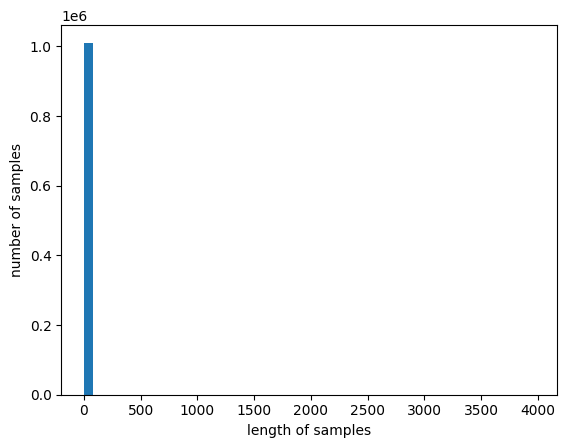

In [30]:
# 훈련 데이터의 리뷰 최대 길이 및 평균 길이 출력
print('리뷰의 최대 길이 :', max(len(review) for review in X_train))
print('리뷰의 평균 길이 :', sum(map(len, X_train)) / len(X_train))

# 리뷰 길이 분포를 히스토그램 그리기
plt.hist([len(review) for review in X_train], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [31]:
# 특정 길이(max_len) 이하의 샘플 비율 출력
def below_threshold_len(max_len, nested_list):
	count = 0
	for sentence in nested_list:
		if len(sentence) <= max_len:
			count += 1
	print(f'길이가 {max_len}이하인 샘플의 비율 {(count) / len(nested_list) * 100}')


# 특정 길이(max_len) 이하의 샘플 비율 출력
max_len = 75
below_threshold_len(max_len, X_train)

길이가 75이하인 샘플의 비율 99.98446362905875


In [32]:
# 훈련 및 테스트 데이터를 특정 길이(max_len)로 패딩
X_train = pad_sequences(X_train, maxlen=max_len)
X_test = pad_sequences(X_test, maxlen=max_len)

##학습 시작##

In [46]:
from tensorflow.keras.layers import Embedding, Dense, GRU
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# 임베딩 차원과 은닉 유닛 수 설정
embedding_dim = 100
hidden_units = 128

# 모델 구성
model = Sequential()
model.add(Embedding(vocab_size, embedding_dim))
model.add(GRU(hidden_units))
model.add(Dense(1, activation='sigmoid'))

# 조기 종료 및 모델 체크포인트 설정
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint('activity_distinction_v1.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)

# 모델 컴파일 및 훈련
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(X_train, Y_train, epochs=6, callbacks=[es, mc], batch_size=64, validation_split=0.2)

Epoch 1/6
12632/12632 [==============================] - 720s 57ms/step - loss: 0.5307 - acc: 0.7142 - val_loss: 0.5094 - val_acc: 0.7299
Epoch 2/6
12632/12632 [==============================] - 715s 57ms/step - loss: 0.4984 - acc: 0.7422 - val_loss: 0.4972 - val_acc: 0.7393
Epoch 3/6
12632/12632 [==============================] - 719s 57ms/step - loss: 0.4833 - acc: 0.7550 - val_loss: 0.4941 - val_acc: 0.7437
Epoch 4/6
12632/12632 [==============================] - 730s 58ms/step - loss: 0.4740 - acc: 0.7613 - val_loss: 0.4932 - val_acc: 0.7435
Epoch 5/6
12632/12632 [==============================] - 748s 59ms/step - loss: 0.4670 - acc: 0.7661 - val_loss: 0.4942 - val_acc: 0.7434
Epoch 6/6
12632/12632 [==============================] - 749s 59ms/step - loss: 0.4604 - acc: 0.7709 - val_loss: 0.4964 - val_acc: 0.7415


In [34]:
from tensorflow.keras.layers import Embedding, Dense, GRU
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import urllib.request
from kiwipiepy import Kiwi
from collections import Counter
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

#모델 로딩 및 평가
loaded_model = load_model('activity_distinction.h5')
print('테스트 정확도 : %.4f' % (loaded_model.evaluate(X_test, Y_test)[1]))

7895/7895 [==============================] - 76s 10ms/step - loss: 0.4961 - acc: 0.7419
테스트 정확도 : 0.7419


In [35]:
#문장 감정 예측 함수
def sentiment_predict(new_sentence: str):
	new_sentence = re.sub('r[^ㄱ-ㅎㅏ-ㅣ가-힣]', '', new_sentence)
	new_sentence = tokenizing(new_sentence)
	encoded = tokenizer.texts_to_sequences([new_sentence])
	pad_new = pad_sequences(encoded, maxlen=max_len)
	score = float(loaded_model.predict(pad_new))

	if score > 0.5:
		print("{:.2f}% 확률로 활동성 리뷰입니다.".format(score * 100))
	else:
		print("{:.2f}% 확률로 비활동성 리뷰입니다.".format((1 - score) * 100))

In [36]:
sentiment_predict('감기')

1/1 [==============================] - 0s 116ms/step
93.56% 확률로 비활동성 리뷰입니다.


In [39]:
lists = ['감기 걸렸당', '운동 갈사람?', '집에 누워있을래', '여행 가실분', '애버렌드 존잼', '독서중', '함 뜨자', '코로나 인가 ㄷㄷ','미세먼지 ㅈㄴ 많네', '롤 ㄱ?', '탕후루 존맛탱 ㄹㅇㅋㅋ', '술배뜰사람 구함', '집순이 등장', '집돌이', '난 뜨개질이 좋아', '헬스 is 마이 라이프', '집에서 귤이나 까먹어 ㅋㅋ', '꽃가루 ㅈㄴ 많노', '여름, 불꽃놀이, 낭만', '치킨 추천점']

In [40]:
for i in lists:
	print(i)
	sentiment_predict(i),print('\n')

감기 걸렸당
1/1 [==============================] - 0s 11ms/step
97.87% 확률로 비활동성 리뷰입니다.


운동 갈사람?
1/1 [==============================] - 0s 9ms/step
68.67% 확률로 활동성 리뷰입니다.


집에 누워있을래
1/1 [==============================] - 0s 8ms/step
88.35% 확률로 비활동성 리뷰입니다.


여행 가실분
1/1 [==============================] - 0s 8ms/step
96.91% 확률로 활동성 리뷰입니다.


애버렌드 존잼
1/1 [==============================] - 0s 8ms/step
70.74% 확률로 활동성 리뷰입니다.


독서중
1/1 [==============================] - 0s 8ms/step
95.04% 확률로 비활동성 리뷰입니다.


함 뜨자
1/1 [==============================] - 0s 7ms/step
68.19% 확률로 활동성 리뷰입니다.


코로나 인가 ㄷㄷ
1/1 [==============================] - 0s 7ms/step
56.68% 확률로 활동성 리뷰입니다.


미세먼지 ㅈㄴ 많네
1/1 [==============================] - 0s 8ms/step
83.35% 확률로 비활동성 리뷰입니다.


롤 ㄱ?
1/1 [==============================] - 0s 7ms/step
51.50% 확률로 비활동성 리뷰입니다.


탕후루 존맛탱 ㄹㅇㅋㅋ
1/1 [==============================] - 0s 8ms/step
56.89% 확률로 활동성 리뷰입니다.


술배뜰사람 구함
1/1 [==============================] - 0s 8ms/step
78.93% 확률로 활동성 리뷰입니다.
